## 5-2. Quantum Circuit learning

**Quantum Circuit Learning** (Quantum Circuit Learning, QCL) is an algorithm for applying quantum computers to machine learning [[1]](https://arxiv.org/abs/1803.00745).  
Like VQE (Variational Quantum Eigensolver) studied in the previous section, it is a **quantum/classical hybrid algorithm** is designed to work on **NISQ** (Noisy Intermediate-Scale Quantum Computer), a medium-scale quantum computer without error correction capability. Experiments using actual NISQ devices have already been conducted, and a paper on an actual implementation of QCL by an IBM experimental team was published in Nature in March 2019 and became a hot topic.

In the following, we first provide an overview of the algorithm and specific learning steps, and finally present an example implementation using the quantum simulator Qulacs.

### Overview of QCL

In recent years, deep learning has been in the limelight in the field of machine learning.  
In deep learning, a deep **neural network** is used to approximate complex functions to learn the relationship between inputs and outputs and to make predictions on new data.  

QCL is a machine learning method that replaces this neural network with a **quantum circuit**, or quantum computer. The use of quantum circuits improves the expressive power of the model because it can learn using **a large number of basis functions in an exponential manner**, taking advantage of the principle of superposition in quantum mechanics. Furthermore, it is believed that the conditions that must be satisfied by quantum circuits (unitarity) can **automatically prevent overfitting**. This is expected to further improve performance beyond that of machine learning on classical computers.   
(For details, see reference [1].)

In neural networks, the function is approximated by adjusting the weight parameter $W$ of each layer, and the concept is exactly the same in QCL.  
In other words, the quantum circuit used in QCL contains multiple "rotation gates," and the function is approximated by adjusting the rotation angle $\theta$ of these rotation gates. The specific procedure is shown below.

### Learning Procedure
1. prepare learning data $\{(x_i, y_i)\}_i$ ($x_i$ is the input data and $y_i$ is the correct data to be predicted from $x_i$ (training data) )
2. prepare a circuit  $U_{\text{in}}(x)$, which is determined by some rule from the input $x$, and set the input state $\{|\psi_{\rm in}(x_i)\rangle\}_i = \{U_{\text{in}}(x_i)|0\rangle\}_i$
3. multiply the input state by the gate $U(\theta)$ depending on the parameter $\theta$ and make the output state $\{|\psi_{\rm out}(x_i, \theta)\rangle = U(\theta)|\psi_{\rm in}(x_i)\rangle \}_i$.
4. measure some observable under the output state and obtain the measured value (e.g., the expected value of $Z$ for the first qubit $\langle Z_1\rangle = \langle \psi_{\rm out} |Z_1|\psi_{\rm out} \rangle$)
5. let $F$ be an appropriate function (sigmoid, softmax, constant times or whatever) and let $F(measurements_i)$ be the model output $y(x_i, \theta)$
6. calculate the "cost function $L(\theta)$" that represents the deviation between the correct data $\{y_i\}_i$ and the model output $\{y(x_i, \theta)\}_i$.
7. find $\theta=\theta^*$ that minimizes the cost function
8. $y(x, \theta^*)$ is the desired predictive model

(In QCL, input data $x$ is first transformed to a quantum state using $U_{\text{in}}(x)$. Then, by using a variational quantum circuit $U(\theta)$ and measurements, the output $y$ is obtained. (In the figure, the output is $\langle B(x,\theta)\rangle$) (Source: Modified from Figure 1 in reference [1])

### Implementation using the quantum simulator Qulacs

In the following, as a demonstration of function approximation, let's perform fitting of the sin function $y=\sin(\pi x)$ .

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

In [2]:
########  parameter  #############
nqubit = 3 ##number of qubits
c_depth = 3  ## depth of circuit
time_step = 0.77  ##Elapsed time of time evolution by random Hamiltonian

## Take number_x_train points from [x_min, x_max] randomly and use them as the training data.
x_min = - 1.; x_max = 1.;
num_x_train = 50

## The 1-variable function we want to learn
func_to_learn = lambda x: np.sin(x*np.pi)

##Seed of random numbers
random_seed = 0

## Initialize random number generator
np.random.seed(random_seed)

#### 学習データの準備
#### Prepare training data

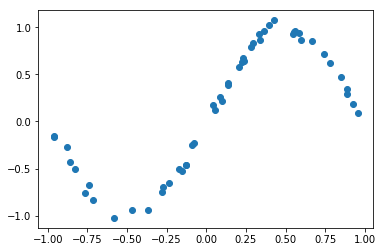

In [32]:
#### Prepare training data

x_train = x_min + (x_max - x_min) * np.random.rand(num_x_train)
y_train = func_to_learn(x_train)

# Add noise to a clean sin function
mag_noise = 0.05
y_train = y_train + mag_noise * np.random.randn(num_x_train)

plt.plot(x_train, y_train, "o"); plt.show()

#### Composition of input state
First, create a gate $U_{\rm in}(x_i)$ to embed the input value $x_i$ into the initial state $|00\ldots0\rangle$.   
Following reference [1], by using the rotation gates $R_j^X(\theta)=e^{i\theta X_j/2}, R_j^Z(\theta)=e^{i\theta Z_j/2}$ and we define the gate as follow.<br> $U_{\rm in}(x) = \prod_j R^Z_j(\cos^{-1} x^2) R^Y_j(\ sin^{-1}x)$.   
The input value $x_i$ will be converted to the quantum state $|\psi_{\rm in}(x_i)\rangle =U_{\rm in}(x_i)|00\ldots0\rangle$.

In [4]:
## Run only if you are in Google Colaboratory or in a local environment where Qulacs is not installed
!pip install qulacs

## Run only in Google Colaboratory or (Linux or Mac) jupyter notebook environment
## Qulacs errors will be output normally.
!pip3 install wurlitzer
%load_ext wurlitzer

In [33]:
#Import required libraries
from qulacs import QuantumState, QuantumCircuit

state = QuantumState(nqubit) # The initial state
state.set_zero_state()
print(state.get_vector())

[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [34]:
# a function to create a gate which encodes x 
def U_in(x):
    U = QuantumCircuit(nqubit)
    
    angle_y = np.arcsin(x)
    angle_z = np.arccos(x**2)

    for i in range(nqubit):
        U.add_RY_gate(i, angle_y)
        U.add_RZ_gate(i, angle_z)
    
    return U

In [35]:
# sample calculation of an input state
x = 0.1 # a sample value
U_in(x).update_quantum_state(state) # calculation of U_in|000>
print(state.get_vector())

[-6.93804351e-01+7.14937415e-01j -3.54871219e-02-3.51340074e-02j
 -3.54871219e-02-3.51340074e-02j  1.77881430e-03-1.76111422e-03j
 -3.54871219e-02-3.51340074e-02j  1.77881430e-03-1.76111422e-03j
  1.77881430e-03-1.76111422e-03j  8.73809020e-05+9.00424970e-05j]


#### Configuration of variational quantum circuit $U(\theta)$
Next, we create a variational quantum circuit $U(\theta)$ to be optimized. This is done in the following three steps.

1. Generation of transverse magnetic field Ising Hamiltonian
2. Creation of rotating gate
3. Alternately combine the gates of 1. and 2. to create one large variational quantum circuit $U(\theta)$


##### 1. Creation of transverse magnetic field Ising Hamiltonian
By performing time evolution using the transverse magnetic field Ising model learned in Section 4-2 and increasing the complexity (entanglement) of the quantum circuit, the expressive power of the model is enhanced. (This part can be skipped unless the reader wants to know the details.)

The Hamiltonian of the transverse Ising model is as follows and is used to define the time evolution operator $U_{\text{rand}} = e^{-iHt}$.


$$
H = \sum_{j=1}^N a_j X_j + \sum_{j=1}^N \sum_{k=1}^{j-1} J_{jk} Z_j Z_k
$$

Here, the coefficients $a$, $J$ are the uniform distribution of $[-1, 1]$.

In [6]:
## basic gates
from qulacs.gate import X, Z
I_mat = np.eye(2, dtype=complex)
X_mat = X(0).get_matrix()
Z_mat = Z(0).get_matrix()

In [37]:
## a function to create fullsize gate.
def make_fullgate(list_SiteAndOperator, nqubit):
    '''
    Receive list_SiteAndOperator = [ [i_0, O_0], [i_1, O_1], ...] ,
    insert Identity into irrelevent qubit, and create (2**nqubit, 2**nqubit) size matrix
    I(0) * ... * O_0(i_0) * ... * O_1(i_1) ...
    '''    list_Site = [SiteAndOperator[0] for SiteAndOperator in list_SiteAndOperator]
    list_SingleGates = []  ## list single 1-qubit gates and reduce them using np.kron
    cnt = 0
    for i in range(nqubit):
        if (i in list_Site):
            list_SingleGates.append( list_SiteAndOperator[cnt][1] )
            cnt += 1
        else: ## insert identity if i is not included in list_Site
            list_SingleGates.append(I_mat)

    return reduce(np.kron, list_SingleGates)

In [38]:
####  Create a time evolution operator by creating a random magnetic field/random coupling Ising Hamiltonian

ham = np.zeros((2**nqubit,2**nqubit), dtype = complex)
for i in range(nqubit): ## i runs 0 to nqubit-1
    Jx = -1. + 2.*np.random.rand() ## random number between -1~1
    ham += Jx * make_fullgate( [ [i, X_mat] ], nqubit)
    for j in range(i+1, nqubit):
        J_ij = -1. + 2.*np.random.rand()
        ham += J_ij * make_fullgate ([ [i, Z_mat], [j, Z_mat]], nqubit)

## Create a time evolution operator by diagonalizing.  H*P = P*D <-> H = P*D*P^dagger
diag, eigen_vecs = np.linalg.eigh(ham)
time_evol_op = np.dot(np.dot(eigen_vecs, np.diag(np.exp(-1j*time_step*diag))), eigen_vecs.T.conj()) # e^-iHT

In [39]:
time_evol_op.shape

(8, 8)

In [40]:
# convert to qulacs gate
from qulacs.gate import DenseMatrix
time_evol_gate = DenseMatrix([i for i in range(nqubit)], time_evol_op)

##### 2. Creation of rotating gate, 3. Configuration of $U(\theta)$


we create a variational quantum circuit $U(\theta)$ by combining time evolution by random transverse magnetic Ising model $U_{\text{rand}}$, and $j \:(=1,2,\cdots n)$ th quantum qubit multiplied by the following rotation gate

$$
U_{\text{rot}}(\theta_j^{(i)}) = R_j^X(\theta_{j1}^{(i)})R_j^Z(\theta_{j2}^{(i)})R_j^X(\theta_{j3}^{(i)})
$$

Here, $i$ is a subscript representing the layer of the quantum circuit, and $U_{\text{rand}}$ and the above rotation are repeated for a total of $d$ layers. In other words, on the whole, we compose the variational Quantum circuit as follows.
In total, there are $3nd$ parameters. the initital values of each $\theta$ follows uniform distribution of $[0, 2\pi]$.

In [41]:
from qulacs import ParametricQuantumCircuit

In [42]:
# composition of gate for output U_out & setting the initial parameter

U_out = ParametricQuantumCircuit(nqubit)
for d in range(c_depth):
    U_out.add_gate(time_evol_gate)
    for i in range(nqubit):
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RX_gate(i,angle)
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RZ_gate(i,angle)
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RX_gate(i,angle)

In [43]:
#  Get a list of initial values ​​for the parameter theta
parameter_count = U_out.get_parameter_count()
theta_init = [U_out.get_parameter(ind) for ind in range(parameter_count)]

In [44]:
theta_init

[6.007250646127814,
 4.046309757767312,
 2.663159813474645,
 3.810080933381979,
 0.12059442161498848,
 1.8948504571449056,
 4.14799267096281,
 1.8226113595664735,
 3.88310546309581,
 2.6940332019609157,
 0.851208649826403,
 1.8741631278382846,
 3.5811951525261123,
 3.7125630518871535,
 3.6085919651139333,
 4.104181793964002,
 4.097285684838374,
 2.71068197476515,
 5.633168398253273,
 2.309459341364396,
 2.738620094343915,
 5.6041197193647925,
 5.065466226710866,
 4.4226624059922806,
 0.6297441057449945,
 5.777279648887616,
 4.487710439107831]

For convenience, create a function to update $\theta$, the parameter of $U(\theta)$

In [45]:
# function to update parameter theta
def set_U_out(theta):    
    global U_out
    
    parameter_count = U_out.get_parameter_count()
    
    for i in range(parameter_count):
        U_out.set_parameter(i, theta[i])

#### Measurement
The output of the model is the expected value of pauli Z of the 0th qubit at the output state $|\psi_{\rm out}\rangle$.
That is, $y(\theta, x_i) = \langle Z_0 \rangle = \langle \psi_{\rm out}|Z_0|\psi_{\rm out}\rangle$.

In [46]:
# create Observable Z_0
from qulacs import Observable
obs = Observable(nqubit)
obs.add_operator(2.,'Z 0') # set Observable 2 * Z. Multipy 2 to widen the final range of <Z>. This constant must be optimized as one of the parameters in order to deal with unknown functions.

In [47]:
obs.get_expectation_value(state)

1.9899748742132404

#### Organize a series of steps into a function
Summarize the flow up to this point and define a function that returns the predicted value $y(x_i, \theta)$ of the model from the input $x_i$.

In [48]:
# A function that returns the model's predicted value y(x_i, theta) from the input x_i
def qcl_pred(x, U_out):
    state = QuantumState(nqubit)
    state.set_zero_state()
    
    # calculate input state
    U_in(x).update_quantum_state(state)
    
    # calculate output state
    U_out.update_quantum_state(state)
    
    # the output of model
    res = obs.get_expectation_value(state)
    
    return res

#### Cost function calculation
The cost function $L(\theta)$ is the mean squared error (MSE) between the training data and the prediction data.

In [49]:
# calculate cost function L
def cost_func(theta):
    '''
    theta: an array of length c_depth * nqubit * 3
    '''
    # update theta, the parameter of U_out
    set_U_out(theta)
    
    # calculate data of num_x_train
    y_pred = [qcl_pred(x, U_out) for x in x_train]
    
    # quadratic loss
    L = ((y_pred - y_train)**2).mean()
    
    return L

In [50]:
# the value of cost function with the initial value of parameter theta
cost_func(theta_init)

1.3889259316193516

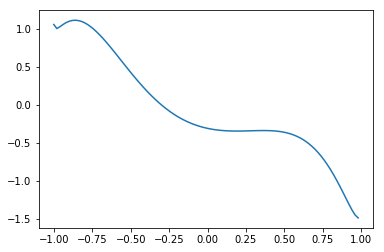

In [51]:
# graph with the initial value of parameter theta
xlist = np.arange(x_min, x_max, 0.02)
y_init = [qcl_pred(x, U_out) for x in xlist]
plt.plot(xlist, y_init)

#### Learning (optimize with scipy.optimize.minimize)
Finally, the preparation is over, and it's finally time to study. Here, for simplicity, the optimization is performed using the Nelder-Mead method, which does not require a gradient formula. When using an optimization method that uses gradients (e.g. BFGS method), a convenient formula for calculating gradients is introduced in Reference [[1]](https://arxiv.org/abs/1803.00745).

In [52]:
from scipy.optimize import minimize

In [53]:
%%time
# Learning (takes about 1-2 minutes on my PC)
result = minimize(cost_func, theta_init, method='Nelder-Mead') 

Wall time: 1min 21s


In [54]:
# value of cost_function after optimization
result.fun 

0.003987076559624744

In [55]:
# solution of theta obtained from optimization
theta_opt = result.x 
print(theta_opt)

[7.17242144 5.4043736  1.27744316 3.09192904 0.13144047 2.13757354
 4.58470259 2.01924008 2.96107066 2.91843537 1.0609229  1.70351774
 6.41114609 6.25686828 2.41619471 3.69387805 4.07551328 1.47666316
 3.4108701  2.28524042 1.75253621 6.47969129 3.18418337 1.58699008
 1.2831137  4.82903335 5.95931349]


#### plotting the result

In [56]:
# Assign optimized theta to U_out
set_U_out(theta_opt)

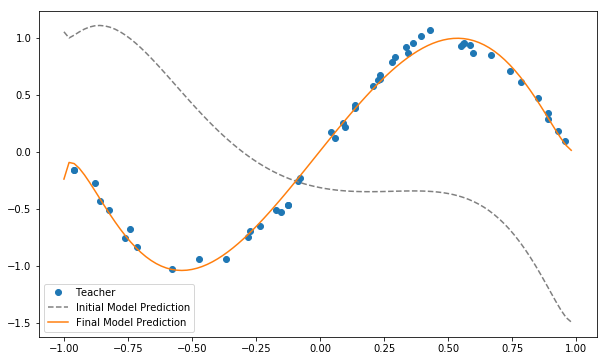

In [57]:
# plot
plt.figure(figsize=(10, 6))

xlist = np.arange(x_min, x_max, 0.02)

# training data
plt.plot(x_train, y_train, "o", label='Teacher')

# Graph under initial value of parameter θ

plt.plot(xlist, y_init, '--', label='Initial Model Prediction', c='gray')

# prediction of model
y_pred = np.array([qcl_pred(x, U_out) for x in xlist])
plt.plot(xlist, y_pred, label='Final Model Prediction')

plt.legend()
plt.show()

It can be seen that the approximation of the sin function is indeed successful.<br>
Here, we dealt with a very simple task of approximating a function with one-dimensional input and output, but it can be extended to approximation of functions with multi-dimensional inputs and outputs and classification problems.
Aspiring readers are encouraged to tackle classification problems of the [Iris dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html), which is one of the representative machine learning datasets.

### Reference
[1] K. Mitarai, M. Negoro, M. Kitagawa, and K. Fujii, “Quantum circuit learning”, [Phys. Rev. A 98, 032309 (2018)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.98.032309), arXiv：https://arxiv.org/abs/1803.00745  
[2] V. Havlicek _et al._ , “Supervised learning with quantum-enhanced feature spaces”, [Nature 567, 209–212 (2019)](https://www.nature.com/articles/s41586-019-0980-2), arXiv：https://arxiv.org/abs/1804.11326